In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import re
import string
from stop_words import get_stop_words

from imblearn.over_sampling import RandomOverSampler

import spacy



In [2]:
pd.set_option("display.max_colwidth", 255)
pd.set_option('display.max_rows', 255)

In [143]:
df = pd.read_excel("training-nltk-mapping3.xlsx")
cnt = df.groupby("CASISTICA_MOTIVAZIONE").count() \
.rename(columns={"Unnamed: 0": "count"})["count"]

In [144]:
cnt.sort_values()

CASISTICA_MOTIVAZIONE
Doc. sanitaria scaduta                             1
Esenzione per ultratrentennale                     1
Variazioni tecniche                                1
Rientro ecoincentivo                               2
Eredi                                              3
Rateizzazione                                      3
Domiciliazione assente                             3
Esenzione successiva                               5
Esenzione PH successiva                            6
Ecoincentivo                                       7
Versamento annullato                               7
CRS intestata a soggetto diverso                   8
No minivoltura                                    10
Esenzione PH eredi                                10
Perdita possesso con DS successiva                13
Domiciliazione tardiva                            16
Rientro in possesso                               18
Sequestro non annotato                            24
Demolizione             

In [145]:
df.groupby([ "CASISTICA_MOTIVAZIONE","CASISTICA_LAVORAZIONE"]).count() \
.sort_values(by=["CASISTICA_MOTIVAZIONE", "Unnamed: 0"]) \
.rename(columns={"Unnamed: 0": "count"})["count"] 


CASISTICA_MOTIVAZIONE                         CASISTICA_LAVORAZIONE                           
Acquisto nel mese di rinnovo; concessionario  DEMOLIZIONE/ESPORTAZIONE TARDIVA                       1
                                              VERS. PRESENTE/VARIATO/INSERITO CONGRUO                1
                                              ATTO DI VENDITA TARDIVO                                2
                                              GIACENZA RIVENDITORI                                   2
                                              GIACENZA RIVENDITORI CON PARZIALE COPERTURA            2
                                              ESENZIONE CONCESSIONARIO TARDIVA                      18
                                              NESSUNA O INIDONEA DOCUMENTAZIONE                     27
Acquisto nel mese di rinnovo; privato         DEMOLIZIONE/ESPORTAZIONE TARDIVA                       1
                                              GIACENZA RIVENDITORI CON PARZIALE C

In [146]:
df[df["CASISTICA_LAVORAZIONE"]=="ATTO DI VENDITA TARDIVO"].groupby("CASISTICA_MOTIVAZIONE").count()

Unnamed: 0  NUMERO_DOCUMENTO  \
CASISTICA_MOTIVAZIONE                                                        
Acquisto nel mese di rinnovo; concessionario           2                 2   
Acquisto nel mese di rinnovo; privato                  7                 7   
Demolizione                                            1                 1   
Domiciliazione tardiva                                 1                 1   
Generica                                              54                54   
No minivoltura                                         1                 1   
Periodo diverso                                        6                 6   
Veicolo diverso                                        1                 1   
Vendita tardiva                                      147               147   

                                              CASISTICA_LAVORAZIONE  \
CASISTICA_MOTIVAZIONE                                                 
Acquisto nel mese di rinnovo; concessionario                      2   
Acquisto nel mese di rinnovo; privato                             7   
Demolizione                                                       1   
Domiciliazione tardiva                                            1   
Generica                                                         54   
No minivoltura                                                    1   
Periodo diverso                                                   6   
Veicolo diverso                                                   1   
Vendita tardiva                                                 147   

                                              NOTE_OPERATORE  
CASISTICA_MOTIVAZIONE                                         
Acquisto nel mese di rinnovo; concessionario               2  
Acquisto nel mese di rinnovo; privato                      7  
Demolizione                                                1  
Domiciliazione tardiva                                     1  
Generica                                                  54  
No minivoltura                                             1  
Periodo diverso                                            6  
Veicolo diverso                                            1  
Vendita tardiva                                          147

<Axes: >

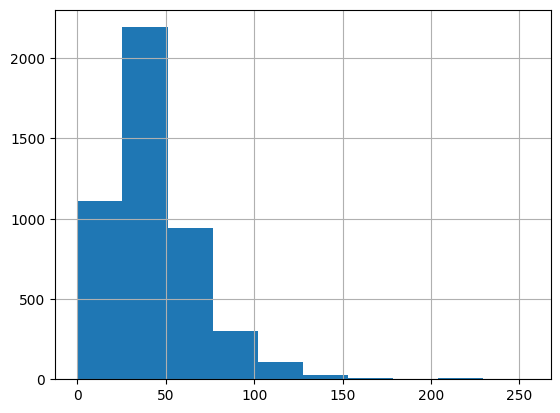

In [147]:
df['NOTE_OPERATORE'].str.len().hist(range=[0, 255])

<Axes: >

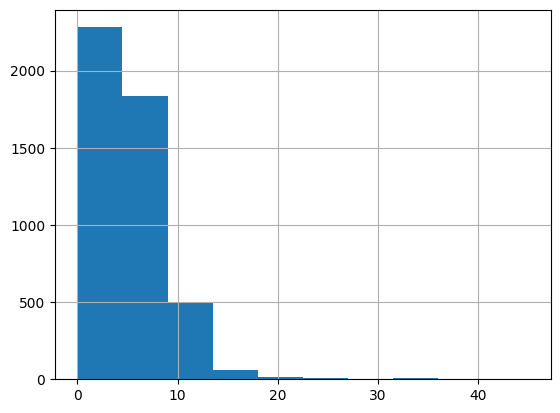

In [148]:
df['NOTE_OPERATORE'].str.split().map(lambda x: len(x)).hist(range=[0, 45])

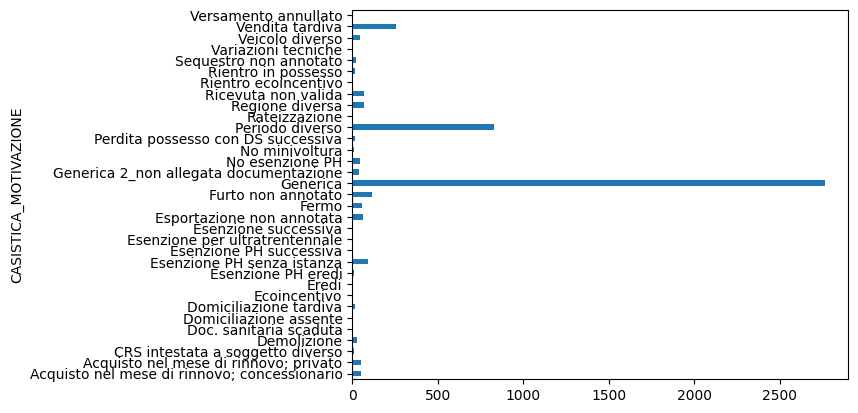

In [149]:

cnt.plot.barh();


In [150]:
df.columns.values.tolist()

['Unnamed: 0',
 'NUMERO_DOCUMENTO',
 'CASISTICA_LAVORAZIONE',
 'NOTE_OPERATORE',
 'CASISTICA_MOTIVAZIONE']

In [15]:
df["CASISTICA_MOTIVAZIONE"].drop_duplicates()


0                                           Generica
9                                    Periodo diverso
13                                   Veicolo diverso
17                                Furto non annotato
19                                             Fermo
23                                   Vendita tardiva
25                               Ricevuta non valida
30                         Esportazione non annotata
86             Acquisto nel mese di rinnovo; privato
150                                      Demolizione
152                           Sequestro non annotato
154                Esenzione PH o storica successiva
160                                    Furto tardivo
161                                     Ecoincentivo
176                                  Regione diversa
179                       Esenzione PH senza istanza
183                                   No minivoltura
979                             Versamento annullato
1610                                 No esenzi

In [54]:
df[df['NOTE_OPERATORE'].str.contains("pra ")].groupby("CASISTICA_MOTIVAZIONE").count()

Unnamed: 0  NUMERO_DOCUMENTO  \
CASISTICA_MOTIVAZIONE                                                  
Acquisto nel mese di rinnovo; privato            5                 5   
Demolizione                                      2                 2   
Domiciliazione tardiva                           1                 1   
EREDI                                            1                 1   
Esportazione non annotata                       21                21   
Fermo                                            2                 2   
Furto non annotato                              44                44   
Generica                                       118               118   
Generica 2_non allegata documentazione           3                 3   
No minivoltura                                   1                 1   
Perdita possesso con DS                          1                 1   
Regione diversa                                  1                 1   
Rientro in possesso                              2                 2   
Sequestro non annotato                           7                 7   
Vendita tardiva                                 29                29   

                                        CASISTICA_LAVORAZIONE  NOTE_OPERATORE  
CASISTICA_MOTIVAZIONE                                                          
Acquisto nel mese di rinnovo; privato                       5               5  
Demolizione                                                 2               2  
Domiciliazione tardiva                                      1               1  
EREDI                                                       1               1  
Esportazione non annotata                                  21              21  
Fermo                                                       2               2  
Furto non annotato                                         44              44  
Generica                                                  118             118  
Generica 2_non allegata documentazione                      3               3  
No minivoltura                                              1               1  
Perdita possesso con DS                                     1               1  
Regione diversa                                             1               1  
Rientro in possesso                                         2               2  
Sequestro non annotato                                      7               7  
Vendita tardiva                                            29              29

Count: 7


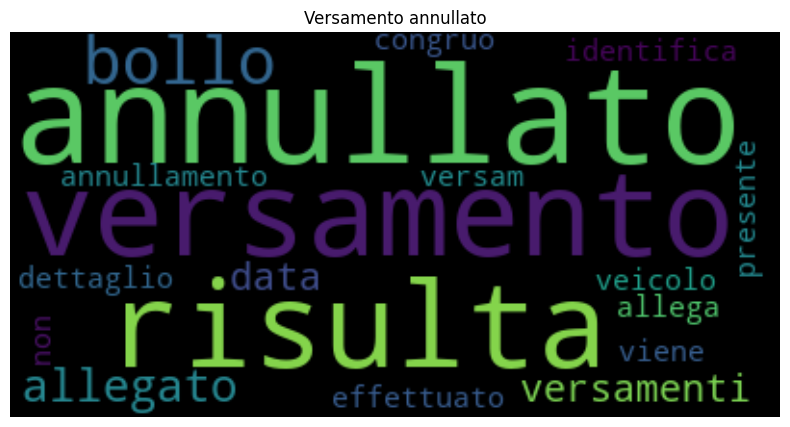

In [51]:
from wordcloud import WordCloud
class_name = "Versamento annullato"
df2 = df[df["CASISTICA_MOTIVAZIONE"] == class_name]
print("Count: {}".format(df2.shape[0]))
wordcloud2 = WordCloud().generate(' '.join(df2['NOTE_OPERATORE'].str.lower()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')  
plt.title(class_name)
plt.show()

In [151]:
df[df["CASISTICA_MOTIVAZIONE"] != "Generica"]

Unnamed: 0  NUMERO_DOCUMENTO              CASISTICA_LAVORAZIONE  \
8          22425      838113553209  NESSUNA O INIDONEA DOCUMENTAZIONE   
9          22433      838218932793        VERSAM PRESENTE NON CONGRUO   
12         22439       68596972278  NESSUNA O INIDONEA DOCUMENTAZIONE   
14         22443      838240147404  NESSUNA O INIDONEA DOCUMENTAZIONE   
16         22447      838083706814  NESSUNA O INIDONEA DOCUMENTAZIONE   
...          ...               ...                                ...   
4701       44688       68299875830  NESSUNA O INIDONEA DOCUMENTAZIONE   
4702       44690      738203345465            ATTO DI VENDITA TARDIVO   
4704       44694       68328887621  NESSUNA O INIDONEA DOCUMENTAZIONE   
4705       44696       68308840246  NESSUNA O INIDONEA DOCUMENTAZIONE   
4706       44697       68326176065            ATTO DI VENDITA TARDIVO   

                                                        NOTE_OPERATORE  \
8                       allegato bollo anno 2017x000d rilavorata esito   
9     allega ricevuta annualità successiva VERSAM PRESENTE NON CONGRUO   
12                                          allega versamento tg targa   
14                                        inviata ricevuta pto periodo   
16                                  presentata pra perdita possesso ds   
...                                                                ...   
4701                                    versamento allegato anno manca   
4702                     venduta dopo scadenza ATTO DI VENDITA TARDIVO   
4704                                       pagamento allegato ricevuta   
4705                                         versamenti allegati manca   
4706               mezzo venduto dopo scadenza ATTO DI VENDITA TARDIVO   

     CASISTICA_MOTIVAZIONE  
8          Periodo diverso  
9          Periodo diverso  
12         Veicolo diverso  
14         Periodo diverso  
16      Furto non annotato  
...                    ...  
4701       Periodo diverso  
4702       Vendita tardiva  
4704   Ricevuta non valida  
4705       Periodo diverso  
4706       Vendita tardiva  

[1953 rows x 5 columns]

In [ ]:
def replace_punct(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

def remove_stopwords(text):
    ita_stop_words = get_stop_words('italian')
    pattern = r'\b(?:' + '|'.join(re.escape(s) for s in ita_stop_words) + r')\b'
    return re.sub(pattern, '', text)


def prune_infrequent_classes(input_df: pd.DataFrame):
    card_thresh = 10
    cnt = input_df[["CASISTICA_MOTIVAZIONE","NOTE_OPERATORE"]].groupby(["CASISTICA_MOTIVAZIONE"]).count().rename({"NOTE_OPERATORE":"count"},axis=1)
    res = input_df.merge(cnt, on="CASISTICA_MOTIVAZIONE")
    res = res[res["count"] >= card_thresh]
    res = res.drop("count", axis=1)
    return res

nlp = spacy.load("it_core_news_sm")
def lemmatize(text):
    doc = nlp(text)
    lemmi = " ".join([token.lemma_ for token in doc])
    return lemmi


#df = prune_infrequent_classes(df)


#df["C"] = df.apply(lambda row: row["CASISTICA_LAVORAZIONE"] in row["NOTE_OPERATORE"]   , axis=1)
#df["X"] =np.where(df["C"], df["NOTE_OPERATORE"],df["NOTE_OPERATORE"] + " " + df["CASISTICA_LAVORAZIONE"])
#df["X"] = df["NOTE_OPERATORE"]  if df["C"].bool else df["NOTE_OPERATORE"] + " " + df["CASISTICA_LAVORAZIONE"]
#df.drop("C", axis=1)


df["X"] = df["NOTE_OPERATORE"]
df["X"] = df["X"].str.replace("x000d", " ")
#df["X"] = df["X"].apply(lambda x: remove_stopwords(x))
#df["X"] = df["X"].apply(lambda x: replace_punct(x))
df["X"] = df["X"].apply(lambda x: lemmatize(x))

df["X"] = df["X"].str.replace("/", " ", regex=True) 
df["X"] = df["X"].str.replace(r"\s+", " ", regex=True) 
#df["X"] = df["X"].str.replace({"à":"a", "è":"e", "ì":"i", "ò":"o", "ù":"u"}, regex=True) 
df["X"] = df["X"].str.lower()






In [153]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold


class_dict = {"Doc. sanitaria scaduta" : 2, 
            "Esenzione per ultratrentennale" : 2, 
            "Variazioni tecniche" : 2, 
            "Furto tardivo" : 2
            }
oversample = RandomOverSampler(sampling_strategy=class_dict)

df_nonGenerica = df[df["CASISTICA_MOTIVAZIONE"] != "Generica"]
X_over, y_over = oversample.fit_resample(df_nonGenerica["NOTE_OPERATORE"].to_numpy().reshape(-1, 1), df_nonGenerica["CASISTICA_MOTIVAZIONE"].to_numpy())
df_over = pd.DataFrame({"NOTE_OPERATORE":X_over[:,0], "CASISTICA_MOTIVAZIONE":y_over})


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

#sss = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
print(sss.get_n_splits(X_over,  y_over))

for i, (train_index, test_index) in enumerate(sss.split(X_over,  y_over)):

    print(f"Fold {i}:")
    test_index_df = df_over.iloc[test_index]
    train_index_df = df_over.iloc[train_index]

    print(train_index.size)
    print(test_index.size)

    check_str = "Rientro ecoincentivo"
    print("------TEST------")
    print(test_index_df[test_index_df["CASISTICA_MOTIVAZIONE"] == check_str])
    print("------TRAIN------")
    print(train_index_df[train_index_df["CASISTICA_MOTIVAZIONE"] == check_str])

    #print(df_over.iloc[test_index])
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")

X_train = train_index_df["NOTE_OPERATORE"]
X_test = test_index_df["NOTE_OPERATORE"]
y_train = train_index_df["CASISTICA_MOTIVAZIONE"]
y_test = test_index_df["CASISTICA_MOTIVAZIONE"]

model_balanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight="balanced"))])
model_unbalanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight=None))])


model_balanced.fit(X_train, y_train)
model_unbalanced.fit(X_train, y_train)


y_pred_balanced = model_balanced.predict(X_test)
y_pred_unbalanced = model_unbalanced.predict(X_test)

print("--------------------------")
print("BAL Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("BAL F1-Score:", f1_score(y_test, y_pred_balanced, average=None))
print("--------------------------")
print("UNBAL Accuracy:", accuracy_score(y_test, y_pred_unbalanced))
print("UNBAL F1-Score:", f1_score(y_test, y_pred_unbalanced, average=None))
print("--------------------------")

f1_score_balanced = f1_score(y_test, y_pred_balanced, average=None)
f1_score_unbalanced = f1_score(y_test, y_pred_unbalanced, average=None)

f1_data = np.array([f1_score_balanced.tolist(), f1_score_unbalanced.tolist()])
f1_score_df = pd.DataFrame(data=np.float64(f1_data[:,:]), columns=model_balanced.classes_, index = ["f1_score_balanced", "f1_score_unbalanced"])



cm = confusion_matrix(y_test, y_pred_balanced, labels=model_balanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_balanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_balanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)



cm = confusion_matrix(y_test, y_pred_unbalanced, labels=model_unbalanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_unbalanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_unbalanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)


ValueError: The {'Furto tardivo'} target class is/are not present in the data.

Accuracy: 0.5588035350101972
F1-Score: 0.5793193398671854
F1-Score: [0.51162791 0.48275862 0.4137931  0.66666667 0.         0.44444444
 0.5        0.8        0.         0.125      0.47169811 0.4
 0.         0.47222222 0.8        0.76086957 0.5        0.53344623
 0.02777778 0.20289855 0.4        0.32       0.80694981 0.
 0.42696629 0.52307692 0.         0.52631579 0.4137931  0.
 1.         0.44827586 0.71296296 0.4       ]


Acquisto nel mese di rinnovo; concessionario  \
f1_score_balanced                                        0.511628   
f1_score_unbalanced                                      0.210526   

                     Acquisto nel mese di rinnovo; privato  Demolizione  \
f1_score_balanced                                 0.482759     0.413793   
f1_score_unbalanced                               0.461538     0.142857   

                     Doc. sanitaria scaduta  Domiciliazione assente  \
f1_score_balanced                  0.666667                     0.0   
f1_score_unbalanced                0.000000                     0.0   

                     Domiciliazione tardiva  EREDI  Ecoincentivo  \
f1_score_balanced                  0.444444    0.5           0.8   
f1_score_unbalanced                0.250000    0.0           0.0   

                     Esenzione PH eredi  Esenzione PH o storica successiva  \
f1_score_balanced                   0.0                              0.125   
f1_score_unbalanced                 0.0                              0.000   

                     Esenzione PH senza istanza  \
f1_score_balanced                      0.471698   
f1_score_unbalanced                    0.380952   

                     Esenzione per ultratrentennale  Esenzione successiva  \
f1_score_balanced                               0.4                   0.0   
f1_score_unbalanced                             0.0                   0.0   

                     Esportazione non annotata     Fermo  Furto non annotato  \
f1_score_balanced                     0.472222  0.800000            0.760870   
f1_score_unbalanced                   0.266667  0.758621            0.777778   

                     Furto tardivo  Generica  \
f1_score_balanced              0.5  0.533446   
f1_score_unbalanced            0.0  0.839428   

                     Generica 2_non allegata documentazione  No esenzione PH  \
f1_score_balanced                                  0.027778         0.202899   
f1_score_unbalanced                                0.000000         0.125000   

                     No minivoltura  Perdita possesso con DS  Periodo diverso  \
f1_score_balanced               0.4                     0.32         0.806950   
f1_score_unbalanced             0.0                     0.00         0.835341   

                     Rateizzazione  Regione diversa  Ricevuta non valida  \
f1_score_balanced              0.0         0.426966             0.523077   
f1_score_unbalanced            0.0         0.388889             0.166667   

                     Rientro ecoincentivo  Rientro in possesso  \
f1_score_balanced                     0.0             0.526316   
f1_score_unbalanced                   0.0             0.000000   

                     Sequestro non annotato  Storico  Variazioni tecniche  \
f1_score_balanced                  0.413793      0.0                  1.0   
f1_score_unbalanced                0.000000      0.0                  0.0   

                     Veicolo diverso  Vendita tardiva  Versamento annullato  
f1_score_balanced           0.448276         0.712963                   0.4  
f1_score_unbalanced         0.600000         0.736196                   0.0

Text(0.5, 0.05, 'Prediction')

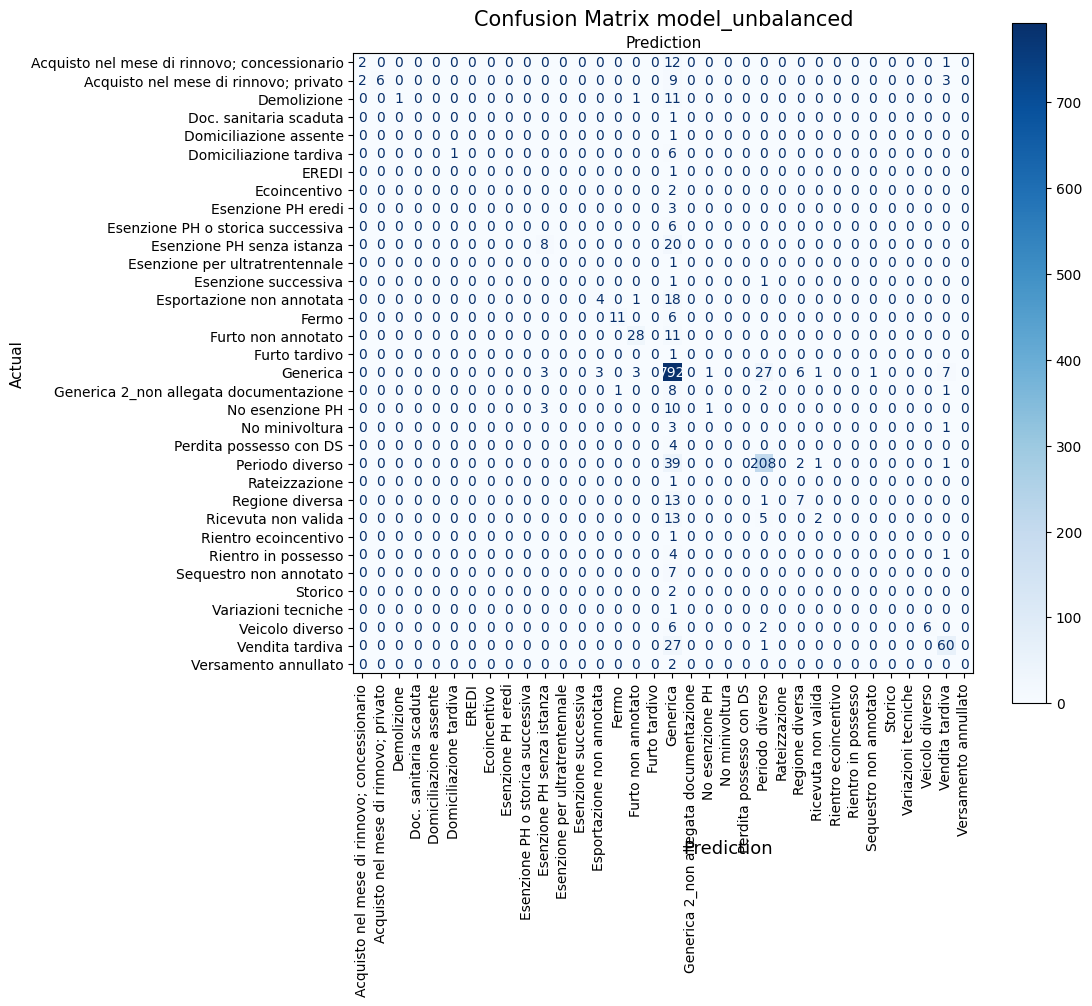

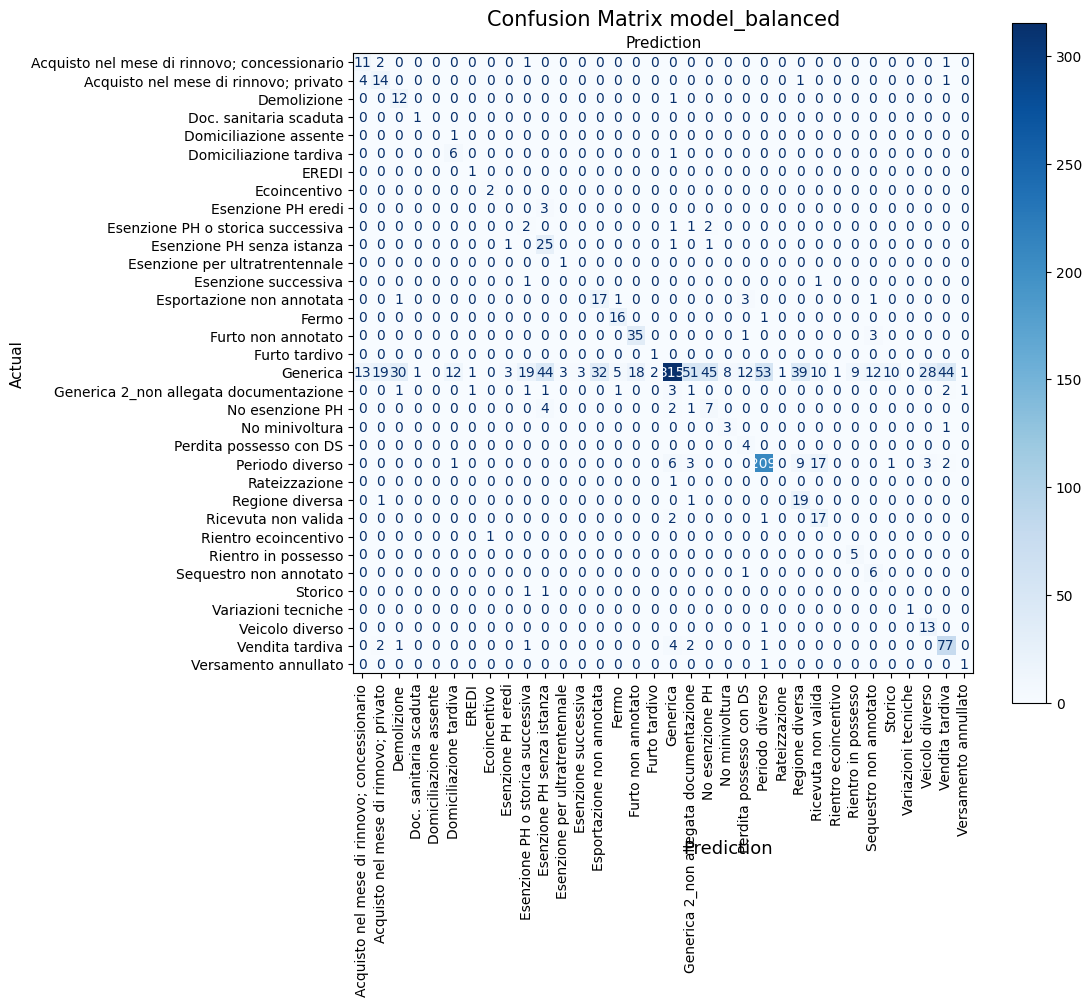

In [128]:
#X_train, X_test, y_train, y_test = train_test_split(df["NOTE_OPERATORE"], df["CASISTICA_MOTIVAZIONE"], test_size=0.2, random_state=42)


class_dict = {"Doc. sanitaria scaduta" : 2, 
            "Esenzione per ultratrentennale" : 2, 
            "Variazioni tecniche" : 2, 
            "Furto tardivo" : 2
            }
oversample = RandomOverSampler(sampling_strategy=class_dict)

X_over, y_over = oversample.fit_resample(df["NOTE_OPERATORE"].to_numpy().reshape(-1, 1), df["CASISTICA_MOTIVAZIONE"].to_numpy())
df_over = pd.DataFrame({"NOTE_OPERATORE":X_over[:,0], "CASISTICA_MOTIVAZIONE":y_over})


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

for i, (train_index, test_index) in enumerate(sss.split(X_over,  y_over)):
    test_index_df = df_over.iloc[test_index]
    train_index_df = df_over.iloc[train_index]


X_train = train_index_df["NOTE_OPERATORE"]
X_test = test_index_df["NOTE_OPERATORE"]
y_train = train_index_df["CASISTICA_MOTIVAZIONE"]
y_test = test_index_df["CASISTICA_MOTIVAZIONE"]




model_balanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight="balanced"))])
model_unbalanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight=None))])


model_balanced.fit(X_train, y_train)
model_unbalanced.fit(X_train, y_train)


y_pred_balanced = model_balanced.predict(X_test)
y_pred_unbalanced = model_unbalanced.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("F1-Score:", f1_score(y_test, y_pred_balanced, average="weighted"))
print("F1-Score:", f1_score(y_test, y_pred_balanced, average=None))

f1_score_balanced = f1_score(y_test, y_pred_balanced, average=None)
f1_score_unbalanced = f1_score(y_test, y_pred_unbalanced, average=None)

f1_data = np.array([f1_score_balanced.tolist(), f1_score_unbalanced.tolist()])
f1_score_df = pd.DataFrame(data=np.float64(f1_data[:,:]), columns=model_balanced.classes_, index = ["f1_score_balanced", "f1_score_unbalanced"])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   display(f1_score_df)

cm = confusion_matrix(y_test, y_pred_unbalanced, labels=model_unbalanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_unbalanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_unbalanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)


cm = confusion_matrix(y_test, y_pred_balanced, labels=model_balanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_balanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_balanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)


In [131]:
f1_score_df_nonTransformed = f1_score_df.copy()

Accuracy: 0.5513256288239293
F1-Score: 0.5755908999171561
F1-Score: [0.52380952 0.47457627 0.42857143 0.66666667 0.         0.48
 0.5        0.8        0.16666667 0.17142857 0.48076923 0.4
 0.         0.4        0.72727273 0.70967742 0.5        0.53435115
 0.02702703 0.21538462 0.375      0.28571429 0.7960396  0.
 0.40860215 0.45070423 0.         0.5        0.5        0.
 1.         0.45614035 0.73584906 0.        ]


Acquisto nel mese di rinnovo; concessionario  \
f1_score_balanced                                         0.52381   
f1_score_unbalanced                                       0.20000   

                     Acquisto nel mese di rinnovo; privato  Demolizione  \
f1_score_balanced                                 0.474576     0.428571   
f1_score_unbalanced                               0.518519     0.444444   

                     Doc. sanitaria scaduta  Domiciliazione assente  \
f1_score_balanced                  0.666667                     0.0   
f1_score_unbalanced                0.000000                     0.0   

                     Domiciliazione tardiva  EREDI  Ecoincentivo  \
f1_score_balanced                      0.48    0.5           0.8   
f1_score_unbalanced                    0.00    0.0           0.0   

                     Esenzione PH eredi  Esenzione PH o storica successiva  \
f1_score_balanced              0.166667                           0.171429   
f1_score_unbalanced            0.000000                           0.000000   

                     Esenzione PH senza istanza  \
f1_score_balanced                      0.480769   
f1_score_unbalanced                    0.390244   

                     Esenzione per ultratrentennale  Esenzione successiva  \
f1_score_balanced                               0.4                   0.0   
f1_score_unbalanced                             0.0                   0.0   

                     Esportazione non annotata     Fermo  Furto non annotato  \
f1_score_balanced                     0.400000  0.727273            0.709677   
f1_score_unbalanced                   0.275862  0.714286            0.805970   

                     Furto tardivo  Generica  \
f1_score_balanced              0.5  0.534351   
f1_score_unbalanced            0.0  0.841496   

                     Generica 2_non allegata documentazione  No esenzione PH  \
f1_score_balanced                                  0.027027         0.215385   
f1_score_unbalanced                                0.000000         0.125000   

                     No minivoltura  Perdita possesso con DS  Periodo diverso  \
f1_score_balanced             0.375                 0.285714         0.796040   
f1_score_unbalanced           0.000                 0.000000         0.821643   

                     Rateizzazione  Regione diversa  Ricevuta non valida  \
f1_score_balanced              0.0         0.408602             0.450704   
f1_score_unbalanced            0.0         0.411765             0.000000   

                     Rientro ecoincentivo  Rientro in possesso  \
f1_score_balanced                     0.0                  0.5   
f1_score_unbalanced                   0.0                  0.0   

                     Sequestro non annotato  Storico  Variazioni tecniche  \
f1_score_balanced                       0.5      0.0                  1.0   
f1_score_unbalanced                     0.0      0.0                  0.0   

                     Veicolo diverso  Vendita tardiva  Versamento annullato  
f1_score_balanced            0.45614         0.735849                   0.0  
f1_score_unbalanced          0.00000         0.743902                   0.0

Text(0.5, 0.05, 'Prediction')

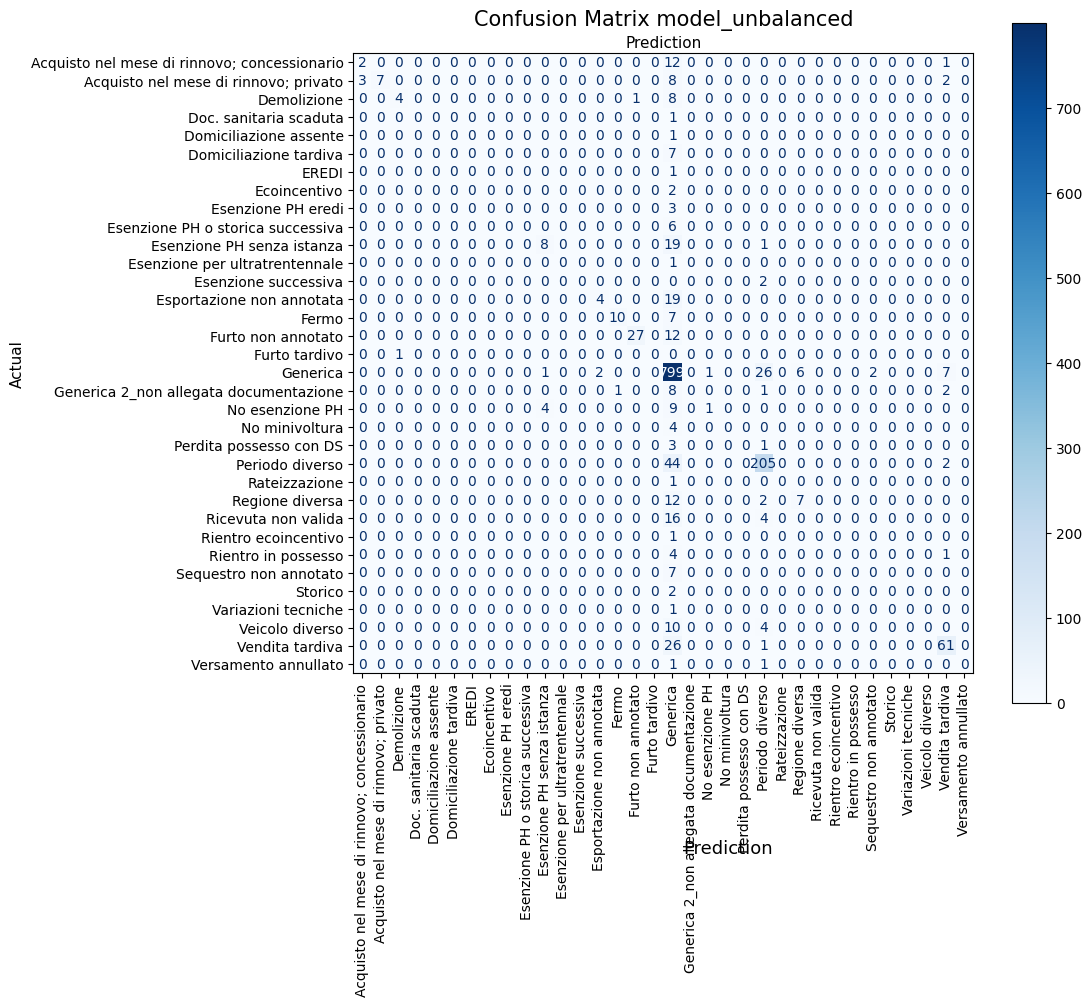

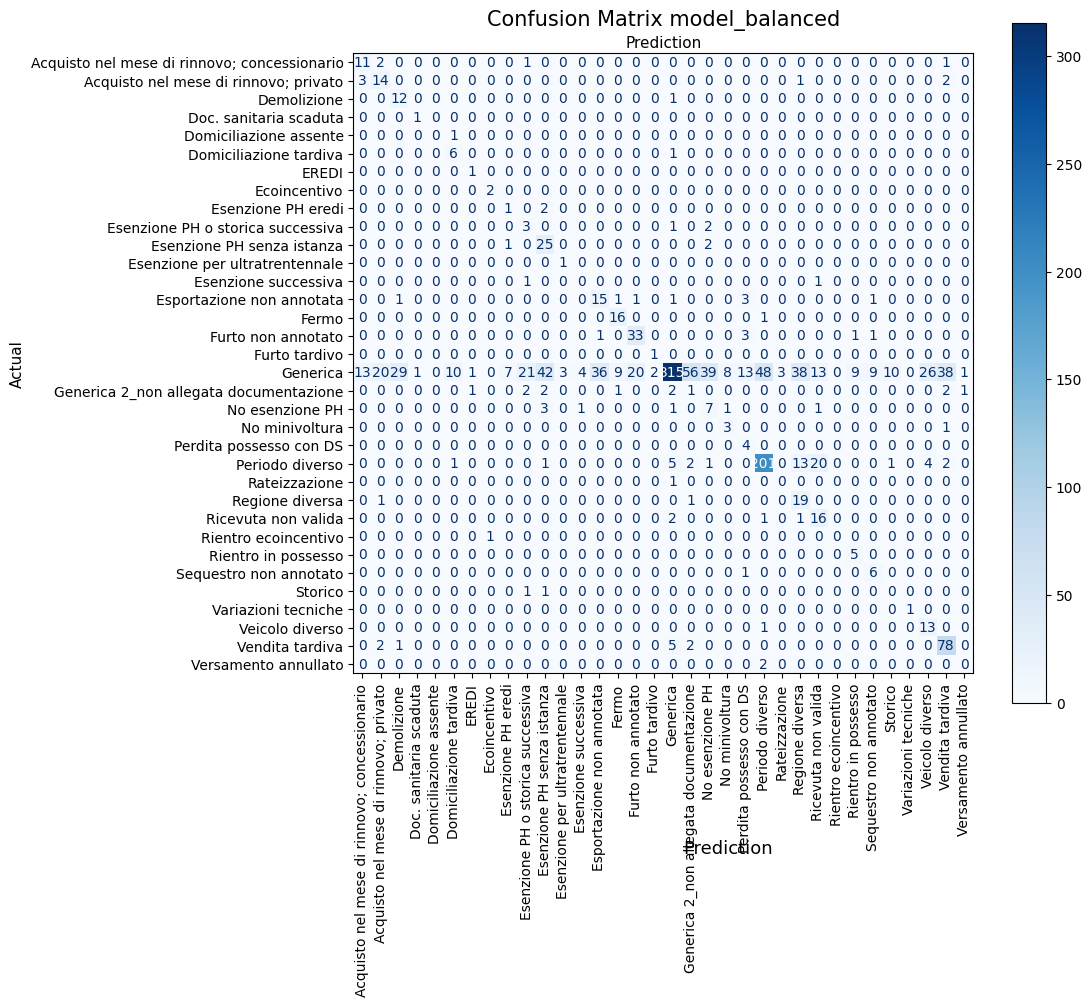

In [132]:
#X_train, X_test, y_train, y_test = train_test_split(df["NOTE_OPERATORE"], df["CASISTICA_MOTIVAZIONE"], test_size=0.2, random_state=42)


class_dict = {"Doc. sanitaria scaduta" : 2, 
            "Esenzione per ultratrentennale" : 2, 
            "Variazioni tecniche" : 2, 
            "Furto tardivo" : 2
            }
oversample = RandomOverSampler(sampling_strategy=class_dict)

X_over, y_over = oversample.fit_resample(df["X"].to_numpy().reshape(-1, 1), df["CASISTICA_MOTIVAZIONE"].to_numpy())
df_over = pd.DataFrame({"X":X_over[:,0], "CASISTICA_MOTIVAZIONE":y_over})


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

for i, (train_index, test_index) in enumerate(sss.split(X_over,  y_over)):
    test_index_df = df_over.iloc[test_index]
    train_index_df = df_over.iloc[train_index]


X_train = train_index_df["X"]
X_test = test_index_df["X"]
y_train = train_index_df["CASISTICA_MOTIVAZIONE"]
y_test = test_index_df["CASISTICA_MOTIVAZIONE"]




model_balanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight="balanced"))])
model_unbalanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight=None))])


model_balanced.fit(X_train, y_train)
model_unbalanced.fit(X_train, y_train)


y_pred_balanced = model_balanced.predict(X_test)
y_pred_unbalanced = model_unbalanced.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("F1-Score:", f1_score(y_test, y_pred_balanced, average="weighted"))
print("F1-Score:", f1_score(y_test, y_pred_balanced, average=None))

f1_score_balanced = f1_score(y_test, y_pred_balanced, average=None)
f1_score_unbalanced = f1_score(y_test, y_pred_unbalanced, average=None)

f1_data = np.array([f1_score_balanced.tolist(), f1_score_unbalanced.tolist()])
f1_score_df = pd.DataFrame(data=np.float64(f1_data[:,:]), columns=model_balanced.classes_, index = ["f1_score_balanced", "f1_score_unbalanced"])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   display(f1_score_df)


cm = confusion_matrix(y_test, y_pred_unbalanced, labels=model_unbalanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_unbalanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_unbalanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)


cm = confusion_matrix(y_test, y_pred_balanced, labels=model_balanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_balanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_balanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)


In [ ]:
f1_score_df_transformed = f1_score_df.copy()

In [136]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   display(f1_score_df_nonTransformed)


Acquisto nel mese di rinnovo; concessionario  \
f1_score_balanced                                        0.511628   
f1_score_unbalanced                                      0.210526   

                     Acquisto nel mese di rinnovo; privato  Demolizione  \
f1_score_balanced                                 0.482759     0.413793   
f1_score_unbalanced                               0.461538     0.142857   

                     Doc. sanitaria scaduta  Domiciliazione assente  \
f1_score_balanced                  0.666667                     0.0   
f1_score_unbalanced                0.000000                     0.0   

                     Domiciliazione tardiva  EREDI  Ecoincentivo  \
f1_score_balanced                  0.444444    0.5           0.8   
f1_score_unbalanced                0.250000    0.0           0.0   

                     Esenzione PH eredi  Esenzione PH o storica successiva  \
f1_score_balanced                   0.0                              0.125   
f1_score_unbalanced                 0.0                              0.000   

                     Esenzione PH senza istanza  \
f1_score_balanced                      0.471698   
f1_score_unbalanced                    0.380952   

                     Esenzione per ultratrentennale  Esenzione successiva  \
f1_score_balanced                               0.4                   0.0   
f1_score_unbalanced                             0.0                   0.0   

                     Esportazione non annotata     Fermo  Furto non annotato  \
f1_score_balanced                     0.472222  0.800000            0.760870   
f1_score_unbalanced                   0.266667  0.758621            0.777778   

                     Furto tardivo  Generica  \
f1_score_balanced              0.5  0.533446   
f1_score_unbalanced            0.0  0.839428   

                     Generica 2_non allegata documentazione  No esenzione PH  \
f1_score_balanced                                  0.027778         0.202899   
f1_score_unbalanced                                0.000000         0.125000   

                     No minivoltura  Perdita possesso con DS  Periodo diverso  \
f1_score_balanced               0.4                     0.32         0.806950   
f1_score_unbalanced             0.0                     0.00         0.835341   

                     Rateizzazione  Regione diversa  Ricevuta non valida  \
f1_score_balanced              0.0         0.426966             0.523077   
f1_score_unbalanced            0.0         0.388889             0.166667   

                     Rientro ecoincentivo  Rientro in possesso  \
f1_score_balanced                     0.0             0.526316   
f1_score_unbalanced                   0.0             0.000000   

                     Sequestro non annotato  Storico  Variazioni tecniche  \
f1_score_balanced                  0.413793      0.0                  1.0   
f1_score_unbalanced                0.000000      0.0                  0.0   

                     Veicolo diverso  Vendita tardiva  Versamento annullato  
f1_score_balanced           0.448276         0.712963                   0.4  
f1_score_unbalanced         0.600000         0.736196                   0.0

In [137]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   display(f1_score_df_transformed)



Acquisto nel mese di rinnovo; concessionario  \
f1_score_balanced                                         0.52381   
f1_score_unbalanced                                       0.20000   

                     Acquisto nel mese di rinnovo; privato  Demolizione  \
f1_score_balanced                                 0.474576     0.428571   
f1_score_unbalanced                               0.518519     0.444444   

                     Doc. sanitaria scaduta  Domiciliazione assente  \
f1_score_balanced                  0.666667                     0.0   
f1_score_unbalanced                0.000000                     0.0   

                     Domiciliazione tardiva  EREDI  Ecoincentivo  \
f1_score_balanced                      0.48    0.5           0.8   
f1_score_unbalanced                    0.00    0.0           0.0   

                     Esenzione PH eredi  Esenzione PH o storica successiva  \
f1_score_balanced              0.166667                           0.171429   
f1_score_unbalanced            0.000000                           0.000000   

                     Esenzione PH senza istanza  \
f1_score_balanced                      0.480769   
f1_score_unbalanced                    0.390244   

                     Esenzione per ultratrentennale  Esenzione successiva  \
f1_score_balanced                               0.4                   0.0   
f1_score_unbalanced                             0.0                   0.0   

                     Esportazione non annotata     Fermo  Furto non annotato  \
f1_score_balanced                     0.400000  0.727273            0.709677   
f1_score_unbalanced                   0.275862  0.714286            0.805970   

                     Furto tardivo  Generica  \
f1_score_balanced              0.5  0.534351   
f1_score_unbalanced            0.0  0.841496   

                     Generica 2_non allegata documentazione  No esenzione PH  \
f1_score_balanced                                  0.027027         0.215385   
f1_score_unbalanced                                0.000000         0.125000   

                     No minivoltura  Perdita possesso con DS  Periodo diverso  \
f1_score_balanced             0.375                 0.285714         0.796040   
f1_score_unbalanced           0.000                 0.000000         0.821643   

                     Rateizzazione  Regione diversa  Ricevuta non valida  \
f1_score_balanced              0.0         0.408602             0.450704   
f1_score_unbalanced            0.0         0.411765             0.000000   

                     Rientro ecoincentivo  Rientro in possesso  \
f1_score_balanced                     0.0                  0.5   
f1_score_unbalanced                   0.0                  0.0   

                     Sequestro non annotato  Storico  Variazioni tecniche  \
f1_score_balanced                       0.5      0.0                  1.0   
f1_score_unbalanced                     0.0      0.0                  0.0   

                     Veicolo diverso  Vendita tardiva  Versamento annullato  
f1_score_balanced            0.45614         0.735849                   0.0  
f1_score_unbalanced          0.00000         0.743902                   0.0

In [ ]:
f1_score_balanced

Accuracy: 0.611740473738414
F1-Score: 0.6405037169113871
F1-Score: [0.60869565 0.4        0.43243243 0.5        0.         0.
 0.24489796 0.31034483 0.66666667 0.71641791 0.61016949 0.04545455
 0.42857143 0.54545455 0.4        0.85995086 0.63829787 0.56
 0.36363636 0.38095238 0.63157895 0.64661654]


Text(0.5, 0.05, 'Prediction')

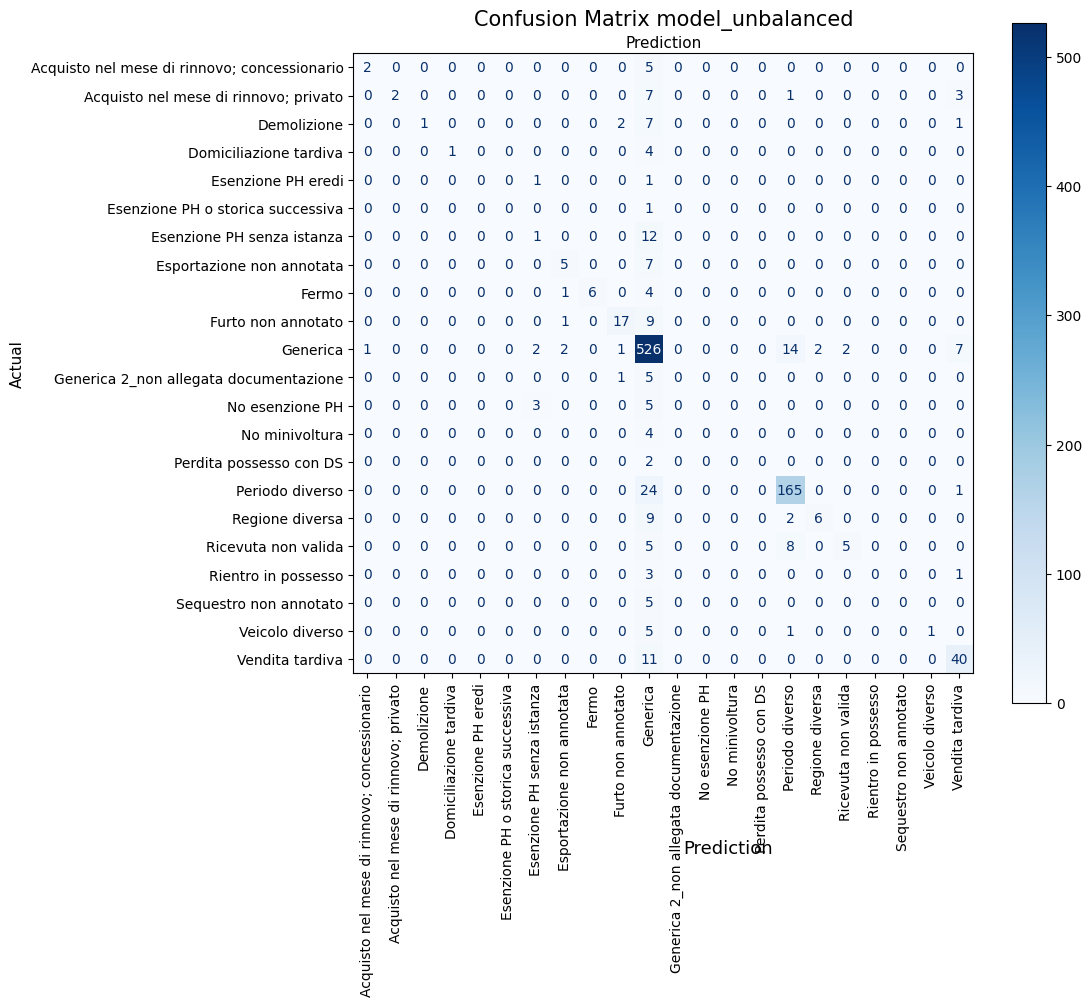

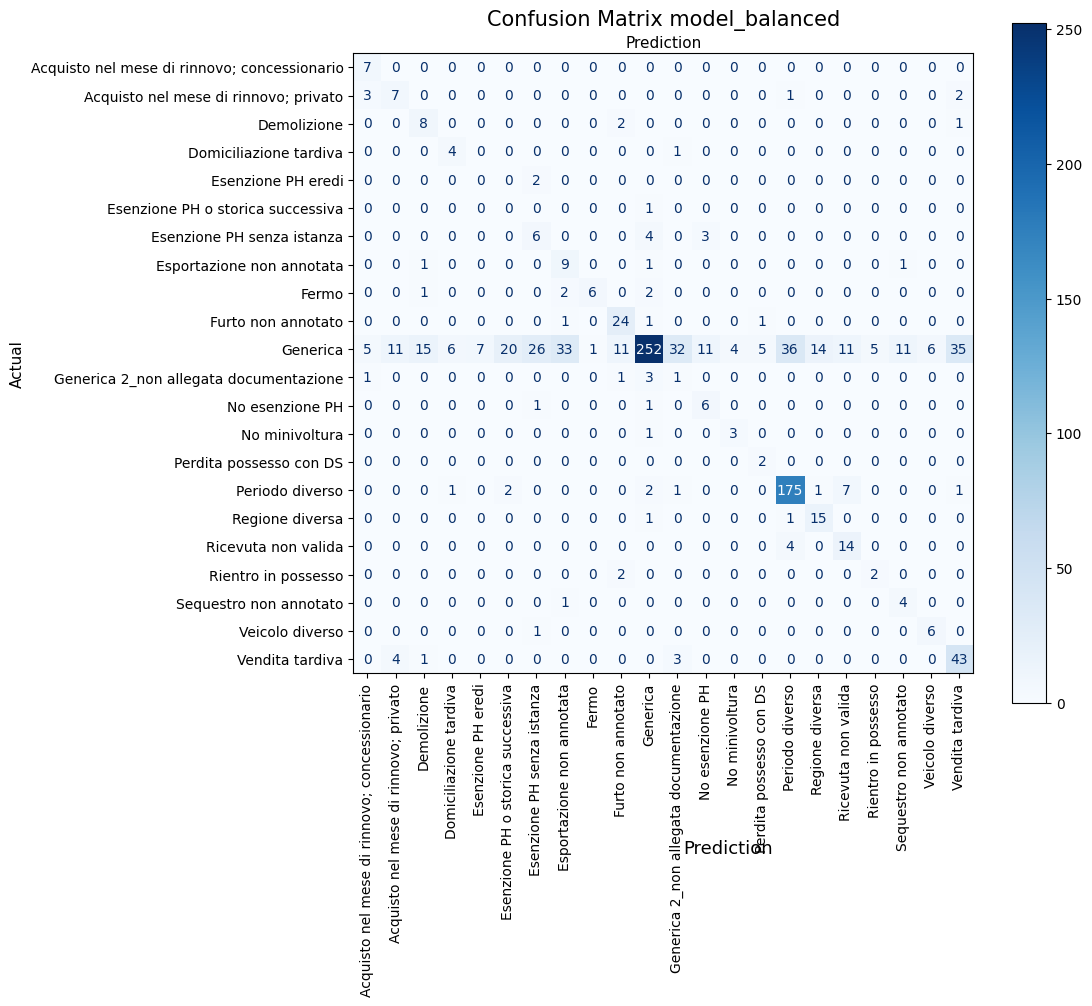

In [62]:

df_pruned = prune_infrequent_classes(df)

X_train, X_test, y_train, y_test = train_test_split(df_pruned["NOTE_OPERATORE"], df_pruned["CASISTICA_MOTIVAZIONE"], test_size=0.2, random_state=42)

model_balanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight="balanced"))])
model_unbalanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight=None))])


model_balanced.fit(X_train, y_train)
model_unbalanced.fit(X_train, y_train)


y_pred_balanced = model_balanced.predict(X_test)
y_pred_unbalanced = model_unbalanced.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("F1-Score:", f1_score(y_test, y_pred_balanced, average="weighted"))

print("F1-Score:", f1_score(y_test, y_pred_balanced, average=None))

f1_score_balanced = f1_score(y_test, y_pred_balanced, average=None)
f1_score_unbalanced = f1_score(y_test, y_pred_unbalanced, average=None)

f1_data = np.array([f1_score_balanced.tolist(), f1_score_unbalanced.tolist()])
f1_score_df = pd.DataFrame(data=np.float64(f1_data[:,:]), columns=model_balanced.classes_, index = ["f1_score_balanced", "f1_score_unbalanced"])



cm = confusion_matrix(y_test, y_pred_unbalanced, labels=model_unbalanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_unbalanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_unbalanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)


cm = confusion_matrix(y_test, y_pred_balanced, labels=model_balanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_balanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_balanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)



Accuracy: 0.7817745803357314
F1-Score: 0.7876875800962205
F1-Score: [0.71428571 0.71428571 0.76190476 0.         0.         0.85714286
 0.         0.4        0.72222222 0.         0.74285714 0.95238095
 0.89795918 0.         0.21052632 0.73684211 0.88888889 0.57142857
 0.88501742 0.87179487 0.69387755 0.         0.88888889 0.25
 0.28571429 0.8        0.83333333 0.66666667]


Text(0.5, 0.05, 'Prediction')

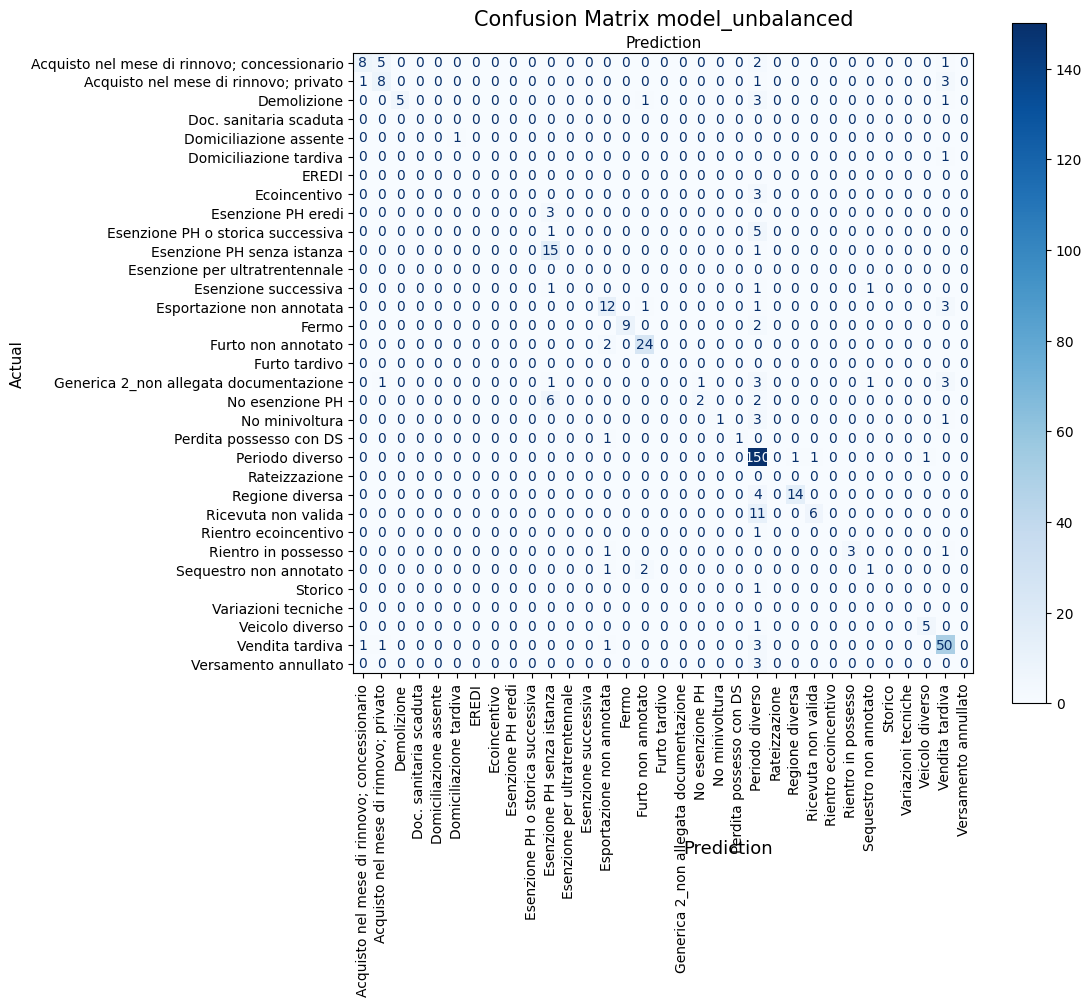

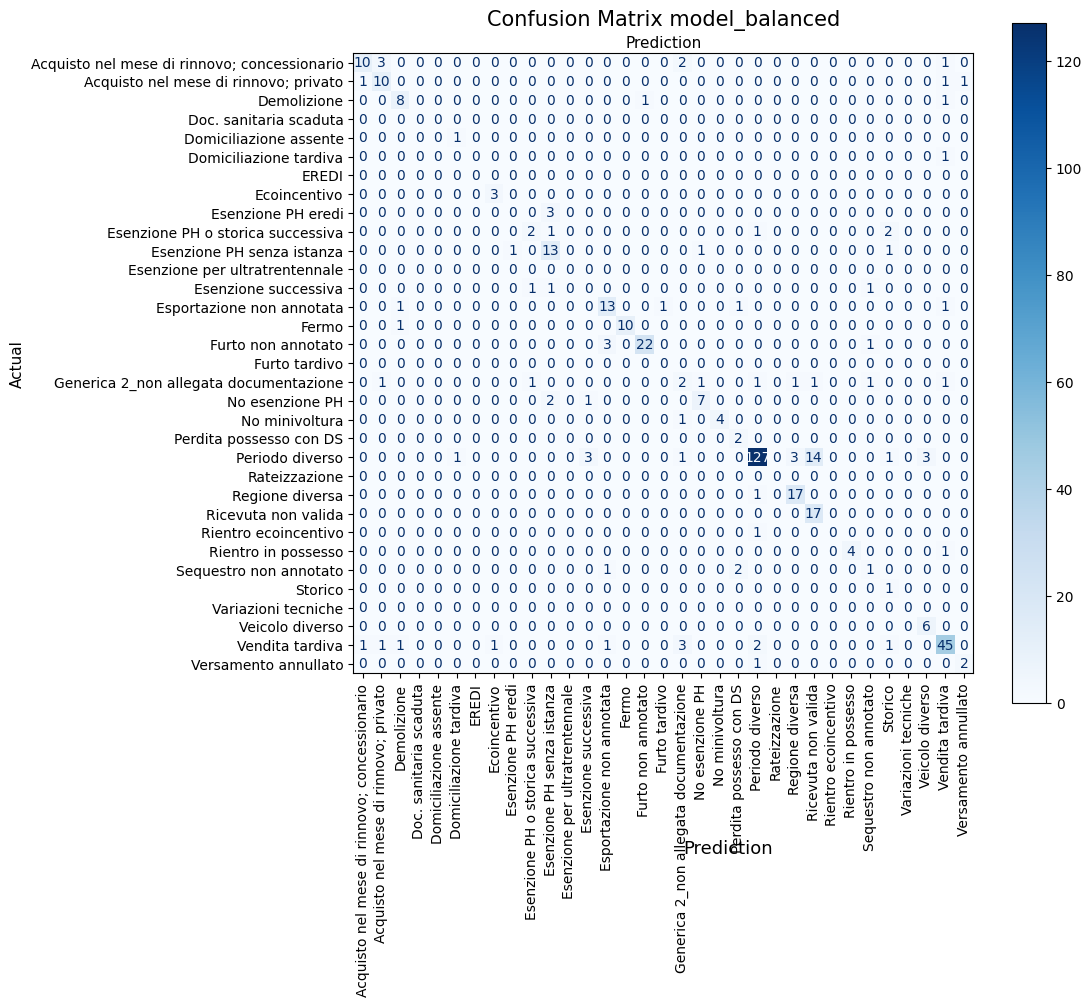

In [65]:
df_nonGenerica = df[df["CASISTICA_MOTIVAZIONE"] != "Generica"]
X_train, X_test, y_train, y_test = train_test_split(df_nonGenerica["NOTE_OPERATORE"], df_nonGenerica["CASISTICA_MOTIVAZIONE"], test_size=0.2, random_state=42)


model_balanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight="balanced"))])
model_unbalanced = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight=None))])


model_balanced.fit(X_train, y_train)
model_unbalanced.fit(X_train, y_train)


y_pred_balanced = model_balanced.predict(X_test)
y_pred_unbalanced = model_unbalanced.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("F1-Score:", f1_score(y_test, y_pred_balanced, average="weighted"))
print("F1-Score:", f1_score(y_test, y_pred_balanced, average=None))

f1_score_balanced = f1_score(y_test, y_pred_balanced, average=None, zero_division=0.0)
f1_score_unbalanced = f1_score(y_test, y_pred_unbalanced, average=None, zero_division=0.0)

#f1_data = np.array([f1_score_balanced.tolist(), f1_score_unbalanced.tolist()])
#f1_score_df = pd.DataFrame(data=np.float64(f1_data[:,:]), columns=model_balanced.classes_, index = ["f1_score_balanced", "f1_score_unbalanced"])

cm = confusion_matrix(y_test, y_pred_unbalanced, labels=model_unbalanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_unbalanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_unbalanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)


cm = confusion_matrix(y_test, y_pred_balanced, labels=model_balanced.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_balanced.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)
plt.title('Confusion Matrix model_balanced', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_bottom()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)




In [323]:
f1_score_unbalanced

array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.        ,
       0.84210526, 0.66666667, 0.9       , 0.94339623, 0.        ,
       0.57142857, 1.        , 0.4       , 0.88452088, 0.93333333,
       0.22222222, 1.        , 0.66666667, 0.44444444, 0.94117647])

In [67]:
df_nonGenerica = df[df["CASISTICA_MOTIVAZIONE"] != "Generica"]
X_train, X_test, y_train, y_test = train_test_split(df_nonGenerica["NOTE_OPERATORE"], df_nonGenerica["CASISTICA_MOTIVAZIONE"], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train)

print(vectorizer.get_feature_names_out())
print(X.shape)
print(X.todense())

model = LogisticRegression()

# Training the model
model.fit(X, y_train)


# Predicting on the test set
y_pred = model.predict(vectorizer.transform(X_test))
dec_fun = model.decision_function(vectorizer.transform(X_test))
pred_prob = model.predict_proba(vectorizer.transform(X_test))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average="weighted"))



['09620x000d' '1003291435x000d' '1003297047x000d' ... 'voltura' 'vuole'
 'x000d']
(1667, 1114)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Accuracy: 0.7529976019184652
F1-Score: 0.709454742723374


In [ ]:

df_generica = df[df["CASISTICA_MOTIVAZIONE"] == "Generica"].reset_index()
X_test_gen, y_test_gen = df_generica["NOTE_OPERATORE"], df_generica["CASISTICA_MOTIVAZIONE"]
y_pred_gen = model.predict(vectorizer.transform(X_test_gen))
dec_fun_gen = model.decision_function(vectorizer.transform(X_test_gen))
pred_prob_gen = model.predict_proba(vectorizer.transform(X_test_gen))

df_res_gen = pd.DataFrame(data=np.int_(pred_prob_gen[:,:]), columns=model.classes_)

print(X_test_gen[1])
print(model.classes_)
print(pred_prob_gen[1])
print(np.argmax(pred_prob_gen[1]))
print(model.classes_[np.argmax(pred_prob_gen[1])])
print(max(pred_prob_gen[1]))
print(pred_prob_gen[1][np.argmax(pred_prob_gen[1])])


thresh = .5
df_res_gen = pd.DataFrame(data=np.float64(pred_prob_gen[:,:]), columns=model.classes_)

df_res_gen_above_thresh = df_res_gen[df_res_gen.max(axis=1)>thresh]
df_res_gen_above_thresh
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df_res_gen_above_thresh)#display(df_generica.iloc[df_res_gen_above_thresh.index])



In [118]:
max_prob_classes = df_res_gen_above_thresh.idxmax(axis=1)
df_generica_classified = df_generica.iloc[max_prob_classes.index]
df_generica_classified["predicted_class"] = max_prob_classes
df_generica_classified

C:\Users\a.torchi\AppData\Local\Temp\ipykernel_34736\531835673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_generica_classified["predicted_class"] = max_prob_classes


index  Unnamed: 0  NUMERO_DOCUMENTO  \
0         0       22401      838165467407   
1         1       22402      838225044100   
3         3       22404       68229236386   
18       28       22479      838140324094   
24       36       22502      838229064041   
...     ...         ...               ...   
2784   4844       44582      738025855471   
2785   4847       44598       68356228483   
2790   4858       44650      738000098638   
2795   4866       44661      838167592717   
2811   4895       44719       68412289534   

                                 CASISTICA_LAVORAZIONE  \
0                    NESSUNA O INIDONEA DOCUMENTAZIONE   
1                    NESSUNA O INIDONEA DOCUMENTAZIONE   
3                    NESSUNA O INIDONEA DOCUMENTAZIONE   
18                          ATTO DI VENDITA INCOMPLETO   
24                   NESSUNA O INIDONEA DOCUMENTAZIONE   
...                                                ...   
2784  PERDITA DI POSS. TARDIVA (FURTO, SEQUESTRO, EC.)   
2785                       ESENZIONE DISABILE RESPINTA   
2790                 NESSUNA O INIDONEA DOCUMENTAZIONE   
2795                 NESSUNA O INIDONEA DOCUMENTAZIONE   
2811                 NESSUNA O INIDONEA DOCUMENTAZIONE   

                                                          NOTE_OPERATORE  \
0                     allega atto vendita illeggibile autenticato giugno   
1                                      dichiara vendita avvenuta ottobre   
3                              allega denuncia furto rilasciata novembre   
18                                        manca allegato autentica firma   
24                          cliente accenna denuncia nessuna annotazione   
...                                                                  ...   
2784                          denuncia querela successiva trascritta pra   
2785                                      esenzione prevista motoveicoli   
2790  cliente allega documentazione esenzione presente nessuna esenzione   
2795                                                   nessun versamento   
2811                                            atto vendita illeggibile   

     CASISTICA_MOTIVAZIONE  \
0                 Generica   
1                 Generica   
3                 Generica   
18                Generica   
24                Generica   
...                    ...   
2784              Generica   
2785              Generica   
2790              Generica   
2795              Generica   
2811              Generica   

                                                                         X  \
0                     allegare atto vendita illeggibile autenticare giugno   
1                                      dichiarare vendita avvenire ottobre   
3                              allegare denuncia furto rilasciare novembre   
18                                      mancare allegato autentico firmare   
24                          cliente accenna denunciare nessuno annotazione   
...                                                                    ...   
2784                          denuncia querela successivo trascrittare pra   
2785                                       esenzione prevedere motoveicoli   
2790  cliente allegare documentazione esenzione presente nessuno esenzione   
2795                                                    nessuno versamento   
2811                                            atto venditare illeggibile   

                 predicted_class  
0                Vendita tardiva  
1                Vendita tardiva  
3             Furto non annotato  
18               Periodo diverso  
24            Furto non annotato  
...                          ...  
2784          Furto non annotato  
2785  Esenzione PH senza istanza  
2790  Esenzione PH senza istanza  
2795             Periodo diverso  
2811             Vendita tardiva  

[585 rows x 8 columns]

In [121]:
df_nonGenerica = df[df["CASISTICA_MOTIVAZIONE"] != "Generica"]
X_train, X_test, y_train, y_test = train_test_split(df_nonGenerica["X"], df_nonGenerica["CASISTICA_MOTIVAZIONE"], test_size=0.2, random_state=42)

model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(penalty="l2", multi_class='multinomial'))])

# Training the model
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predicting on the test set
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.7410071942446043
F1-Score: 0.6937810217431234


c:\Users\a.torchi\Desktop\text_classification\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
